In [1]:
import torch
from torchdiffeq import odeint


# First order equation example

In [2]:
def func(t, z):
    return t

z0 = torch.tensor([0.], dtype=torch.float64)
t = torch.linspace(0., 2., 100, dtype=torch.float64)
out = odeint(func, z0, t)

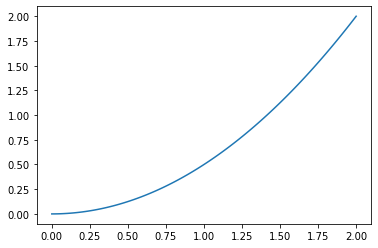

In [3]:
# plot the initial condition
import matplotlib.pyplot as plt
plt.plot(t, out)
plt.show()

# Second order equation example

In [4]:
class Oscillation:
    def __init__(self, km):
        self.km = km
        self.mat = torch.tensor([[0., 1.], [-self.km, 0.]], dtype=torch.float64)

    def solve(self, t, x0, dx0):
        return odeint(self.func, torch.cat([x0, dx0]), t)

    def func(self, t, z):
        # it must be t, z in argument
        # print(self.mat.shape)
        out = z @ self.mat
        return out

torch.Size([1000, 2])


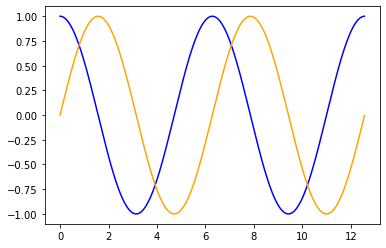

In [5]:
x0 = torch.tensor([1.], dtype=torch.float64)
dx0 = torch.tensor([0.], dtype=torch.float64)

t = torch.linspace(0., 4*3.14, 1000, dtype=torch.float64)
solver = Oscillation(1.)
out = solver.solve(t, x0, dx0)

print(out.shape)

# draw the solution
# choose the color blue 
plt.plot(t, out[:, 0], color='b')
# choose the color orange
plt.plot(t, out[:, 1], color='orange')
plt.show()

# draw the derivative

plt.show()


# Learn ODE function

In [79]:
import torch.nn as nn
from torchdiffeq import odeint_adjoint

class ODEfunc(nn.Module):
    def __init__(self, dim):
        super(ODEfunc, self).__init__()
        self.dim = dim
        self.mid_dim = 200
        self.seq = nn.Sequential(
            nn.Linear(dim, self.mid_dim),
            nn.ReLU(),
            nn.Linear(self.mid_dim, self.mid_dim),
            nn.ReLU(),
            nn.Linear(self.mid_dim, dim),
            nn.Tanh()
        )

    def forward(self, t, x):
        return self.seq(x)


class ODEBlock(nn.Module):
    def __init__(self, odefunc):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        # self.integration_time = torch.tensor([0, 1]).float()

    def forward(self, x, t):
        # integration_time = integration_time.type_as(x)
        out = odeint_adjoint(self.odefunc, x, t)
        return out[1]


In [80]:
class ODEnet(nn.Module):
    def __init__(self, in_dim, mid_dim, out_dim):
        super(ODEnet, self).__init__()

        odefunc = ODEfunc(dim=mid_dim)
        
        self.fc1 = nn.Linear(in_dim, mid_dim)
        self.relu1 = nn.ReLU(inplace=True)
        self.norm1 = nn.BatchNorm1d(mid_dim)
        self.ode_block = ODEBlock(odefunc)  #Use ODE Block
        self.norm2 = nn.BatchNorm1d(mid_dim)
        self.fc2 = nn.Linear(mid_dim, out_dim)

        # count the number of parameters
        print("Number of parameters:", sum([p.numel() for p in self.parameters()]))

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.norm1(out)
        out = self.ode_block(out, torch.flatten(x))
        out = self.norm2(out)
        out = self.fc2(out)

        return out

In [84]:
import torch.nn.functional as F
from tqdm.notebook import trange

def get_random_time_sample(n_samples):
    sample = torch.rand(n_samples)*12*3.14
    # sort it 
    sample = sample.sort(dim=-1).values
    return sample
# train our ODENet on the Oscilation ODE

def train(model, solver, optimizer, device, epochs, n_samples, x0, dx0):
    model.train()
    iterator = trange(epochs)
    # just for the plot part
    true_t = torch.linspace(0., 12*3.14, 3000, dtype=torch.float64)
    true_out_draw = solver.solve(true_t, x0, dx0)

    for i in iterator:
        # get a random time sample
        sample = get_random_time_sample(n_samples)
        # place the initial condition in the first position of the sample
        times = torch.cat([torch.zeros(1), sample], dim=-1).float()
        
        # comput the true output 
        true_out = solver.solve(times, x0, dx0).float()
        
        # compute the output of the model
        out = model(times.to(device))
        # compute the loss
        
        loss = F.mse_loss(out[:,0], true_out[:,0].to(device))
        # compute the gradients
        optimizer.zero_grad()
        loss.backward()
        # update the parameters
        optimizer.step()
        # update the progress bar
        iterator.set_description_str(f'Loss: {loss.item():.4f}')

        if i % 10 == 0:
            # show the output
            plt.plot(true_t.cpu().detach().numpy(), true_out_draw[:,0].cpu().detach().numpy(), 'b')
            plt.plot(times.cpu().detach().numpy(), out[:,0].cpu().detach().numpy(), 'orange')
            plt.show()
        
    return None

# get_random_time_sample(3, 10)
# torch.cat([torch.zeros(3,1), get_random_time_sample(3, 10)], dim=-1).float()


In [82]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ODEnet(1, 200, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 1000
n_samples = 300
x0 = torch.tensor([1.], dtype=torch.float64).to(device)
dx0 = torch.tensor([0.], dtype=torch.float64).to(device)


Number of parameters: 122001


  0%|          | 0/1000 [00:00<?, ?it/s]

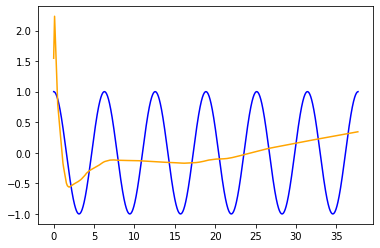

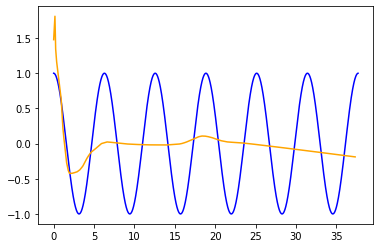

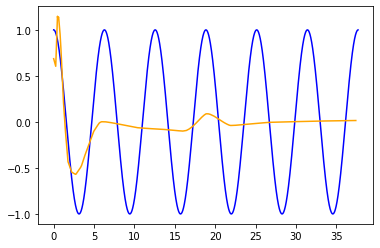

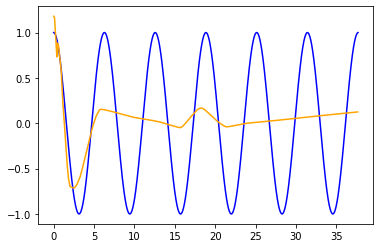

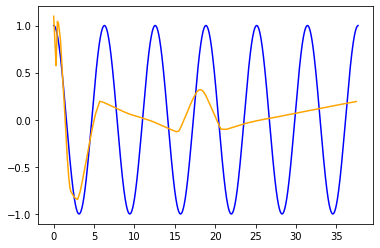

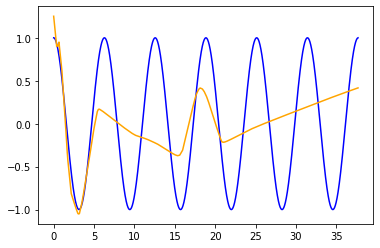

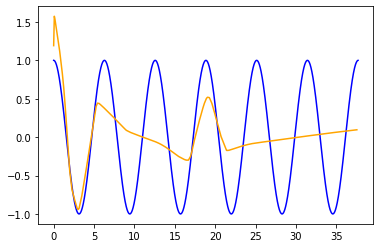

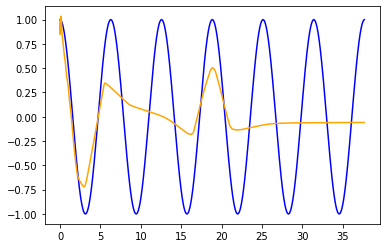

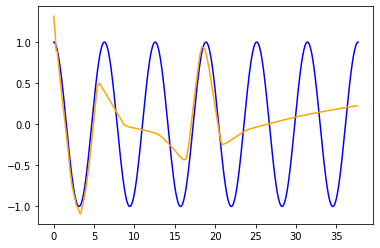

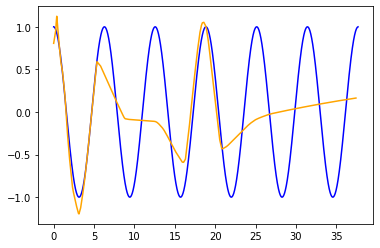

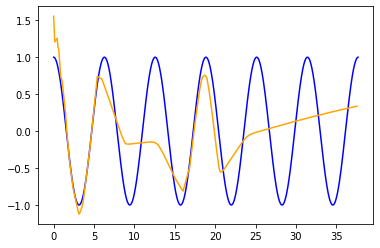

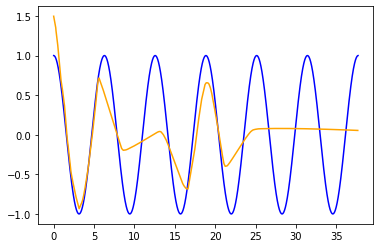

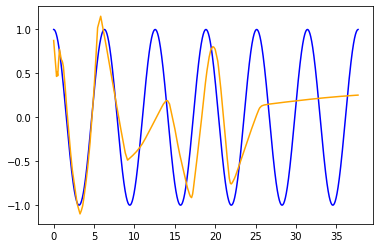

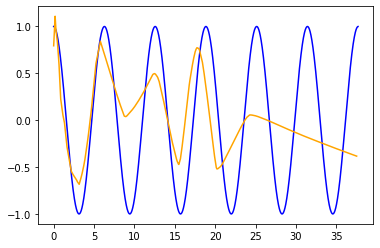

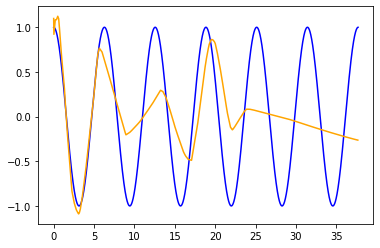

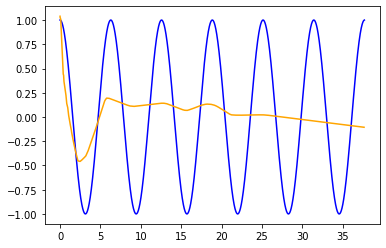

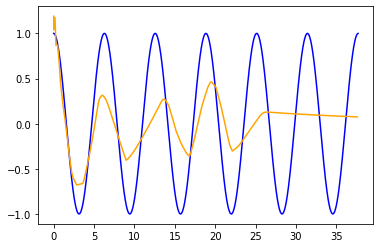

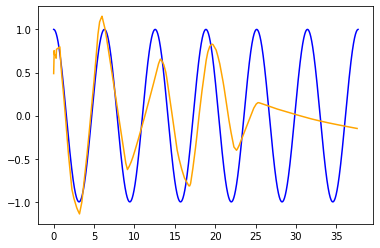

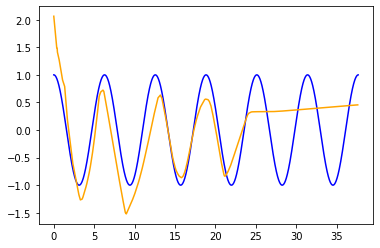

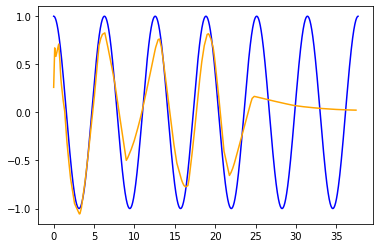

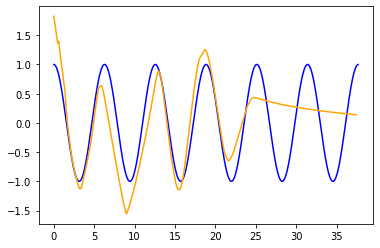

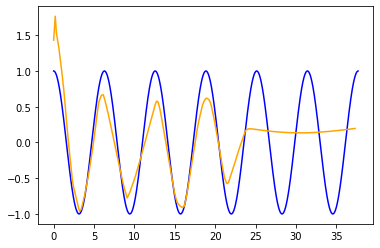

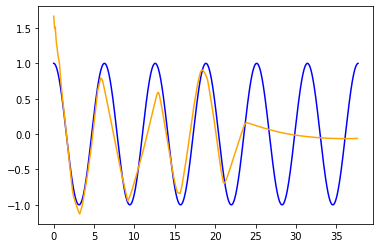

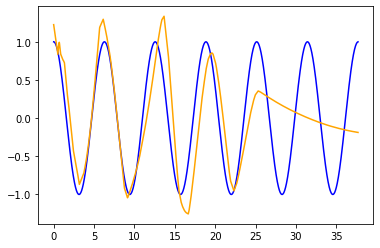

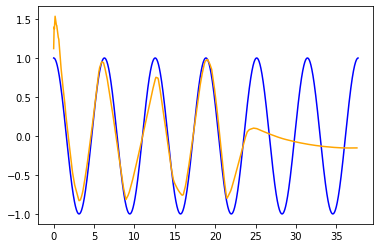

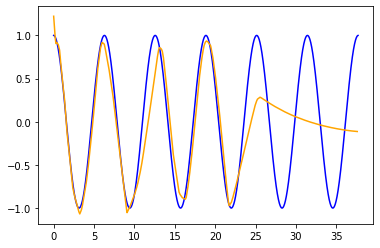

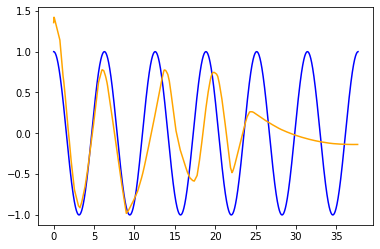

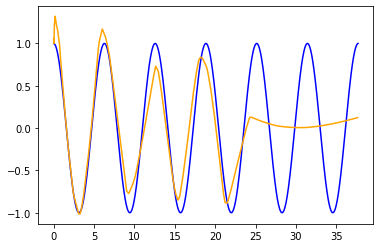

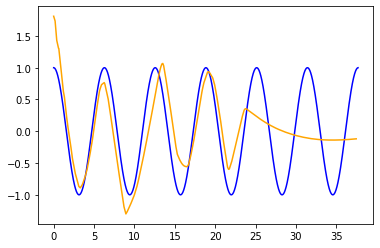

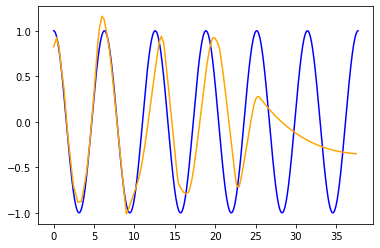

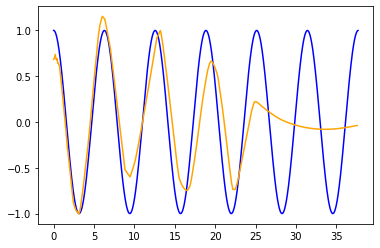

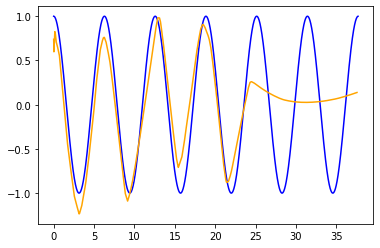

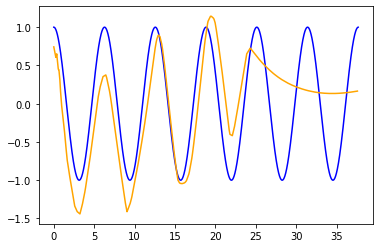

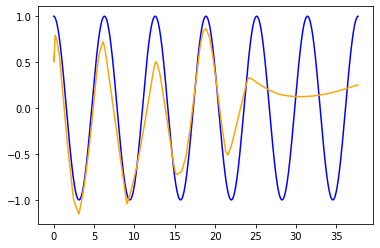

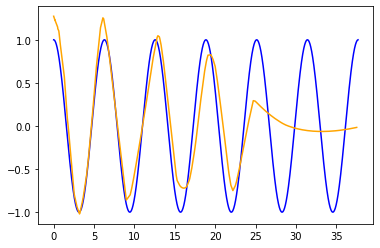

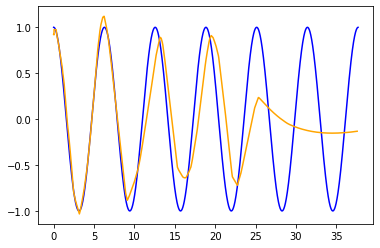

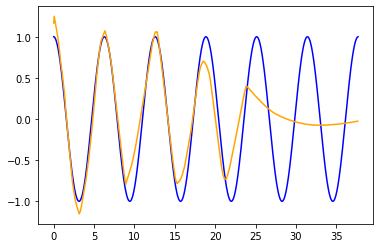

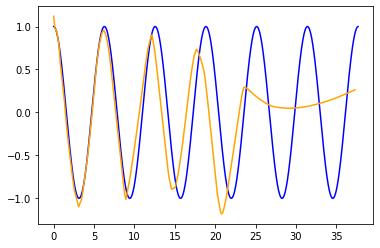

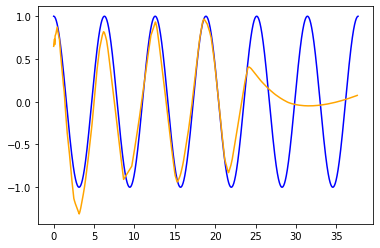

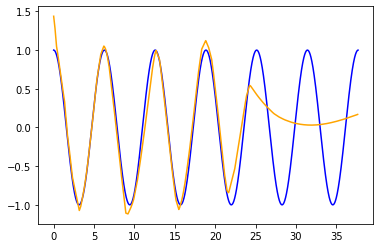

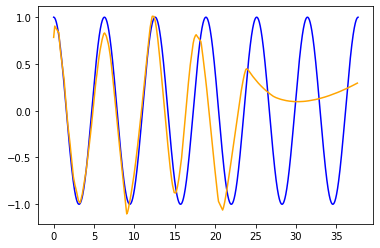

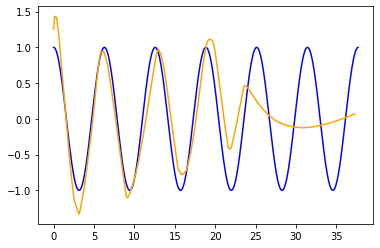

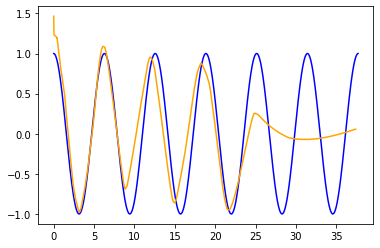

AssertionError: t must be strictly increasing or decreasing

In [85]:
# train the model
losses = train(model, solver, optimizer, device, epochs, n_samples, x0, dx0)

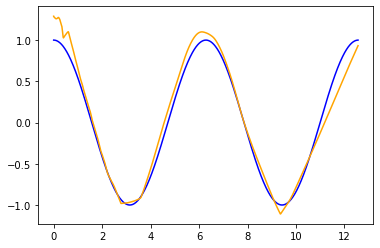

In [117]:
# draw the solution
t = torch.linspace(0., 16*3.14, 2000, dtype=torch.float64).float()
true_out = solver.solve(t, x0, dx0)
f_out = model(t.to(device))
# choose the color blue for true output
plt.plot(t, true_out[:, 0], color='b')
# choose the color orange for model output
plt.plot(t, f_out[:, 0].cpu().detach().numpy() , color='orange')
plt.show()


# Find the ODE that converges the ball motion

In [16]:
import numpy as np

class Ball:
    def __init__(self, x0, r, move_func):
        self.x0 = x0
        self.r = r
        self.x = x0
        self.t = 0
        self.move_func = move_func

    def step(self, dt):
        self.t += dt
        x = self.x
        self.x += dt*self.move_func(self.t, x)
        
        return self.x


def move_fun_circle(t, x, w=1, exp_decay=1.):
    return torch.exp(-torch.tensor(exp_decay*t))*torch.tensor([-w*np.sin(w*t), w*np.cos(w*t)], dtype=torch.float64)    

    


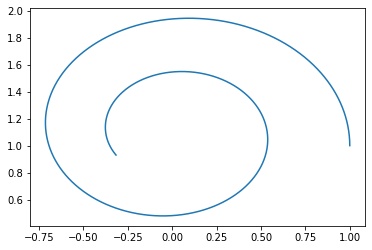

In [38]:
# create a ball and move it
N = 3000
dt = 1./N

ball = Ball(torch.tensor([1.,1.]), 1.,lambda t,x: move_fun_circle(t, x, w=10))
positions = []
for i in range(N):
    # print(ball.x)
    positions.append(ball.x.numpy().copy())
    ball.step(dt)  

positions = np.stack(positions, axis=0)

# print(positions)
# display the positions in a plot 
plt.plot(positions[:,0], positions[:,1])
plt.show()

In [39]:
import torch.nn.functional as F
from tqdm.notebook import trange

class batchGetter:
    def __init__(self, n_samples, total_length, dt, positions, N_train):
        self.times = torch.linspace(0., total_length*dt, total_length, dtype=torch.float64).float()
        self.true_positions = torch.tensor(positions, dtype=torch.float64).float()
        self.train_times = self.times[:N_train]
        self.test_times = self.times[N_train:]
        self.train_positions = self.true_positions[:N_train]
        self.test_positions = self.true_positions[N_train:]
        self.n_samples = n_samples
        self.N_train = N_train
        self.dt = dt
        self.total_length = total_length

    def get_batch(self):
        sample = torch.randint(0, self.N_train, (self.n_samples,))
        batch_times = self.times[sample]
        batch_true_positions = self.train_positions[sample]
        return batch_times, batch_true_positions

# train our ODENet on the Ball motion

def train(model, optimizer, device, epochs, getter, display=100, all_data=False):
    model.train()
    iterator = trange(1, epochs+1)
    # just for the plot part
    

    for i in iterator:
        # get a random time sample
        if all_data:
            batch_times, batch_true_positions = getter.train_times, getter.train_positions
        else:    
            batch_times, batch_true_positions = getter.get_batch()
        # place the initial condition in the first position of the sample
        integration_time = torch.tensor([torch.min(batch_times), torch.max(batch_times)]).float()
        # compute the output of the model
        out = model(batch_times.to(device), integration_time.to(device))
        # compute the loss
        # print(out.shape, batch_true_positions.shape)
        loss = F.mse_loss(out, batch_true_positions.to(device))
        # compute the gradients
        optimizer.zero_grad()
        loss.backward()
        # update the parameters
        optimizer.step()
        # update the progress bar
        iterator.set_description_str(f'Loss: {loss.item():.4f}')

        if i % display == 0:
            # show the output
            predicted_output_train = model(getter.train_times.to(device))
            predicted_output_test = model(getter.test_times.to(device))
            # display in orange the predicted position and in blue the true position of the training set

            # Training set
            plt.plot(getter.train_positions[:,0].cpu().detach().numpy(), 
                    getter.train_positions[:,1].cpu().detach().numpy(), 'b', label="True train")

            plt.plot(predicted_output_train[:,0].cpu().detach().numpy(), 
                    predicted_output_train[:,1].cpu().detach().numpy(), 'orange', label="Predicted train")
            
            # Test set
            plt.plot(getter.test_positions[:,0].cpu().detach().numpy(), 
                    getter.test_positions[:,1].cpu().detach().numpy(), 'cyan', label="True test")
            plt.plot(predicted_output_test[:,0].cpu().detach().numpy(),
                    predicted_output_test[:,1].cpu().detach().numpy(), 'red', label="Predicted test")
            plt.show()
        
    return None

# get_random_time_sample(3, 10)
# torch.cat([torch.zeros(3,1), get_random_time_sample(3, 10)], dim=-1).float()


# Uniform time sampling

## First test using the converging function

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ODEnet(1, 60, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# train the model

Number of parameters: 16702


In [ ]:
epochs = 1000
n_samples = 200
getter = batchGetter(n_samples=n_samples, total_length=N, dt=dt, positions=positions, N_train=2000)
losses = train(model, optimizer, device, epochs, getter, display=50, all_data=True)

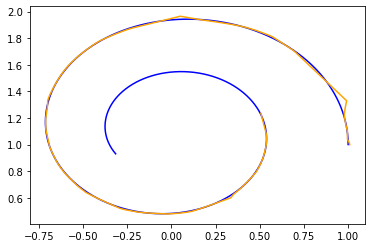

In [48]:
predicted_output = model(getter.times.to(device))
predicted_output_train = model(getter.train_times.to(device))
# display in orange the predicted position and in blue the true position of the training set

# Training set
plt.plot(getter.true_positions[:,0].cpu().detach().numpy(), 
        getter.true_positions[:,1].cpu().detach().numpy(), 'b', label="True")

plt.plot(predicted_output_train[:,0].cpu().detach().numpy(), 
        predicted_output_train[:,1].cpu().detach().numpy(), 'orange', label="Predicted")
plt.show()

In [30]:
epochs = 1000
n_samples = 60
getter = batchGetter(n_samples=n_samples, total_length=N, dt=dt, positions=positions, N_train=800)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ODEnet(1, 60, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# train the model

Number of parameters: 16702


  0%|          | 0/5000 [00:00<?, ?it/s]

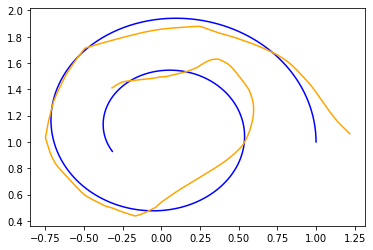

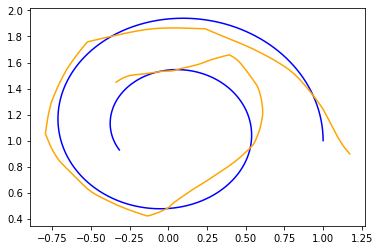

KeyboardInterrupt: 

In [32]:
epochs = 5000
n_samples = 200
getter = batchGetter(n_samples=n_samples, total_length=N, dt=dt, positions=positions, N_train=800)
losses = train(model, optimizer, device, epochs, getter, display=30)
